In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
#import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
#import tqdm
from PIL import Image

%matplotlib inline

In [2]:
train_dir = '../data/dogs-vs-cats/train'
test_dir = '../data/dogs-vs-cats/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(32),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats_train = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs_train = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs_train = ConcatDataset([cats_train, dogs_train])

In [4]:
files_test = [tf for tf in test_files]
catdogs_test = CatDogDataset(test_files, test_dir, mode='test', transform = data_transform)

In [5]:
dataloader_train = DataLoader(catdogs_train, batch_size = 100, shuffle=True)
dataloader_test = DataLoader(catdogs_test, batch_size = 100, shuffle=True)

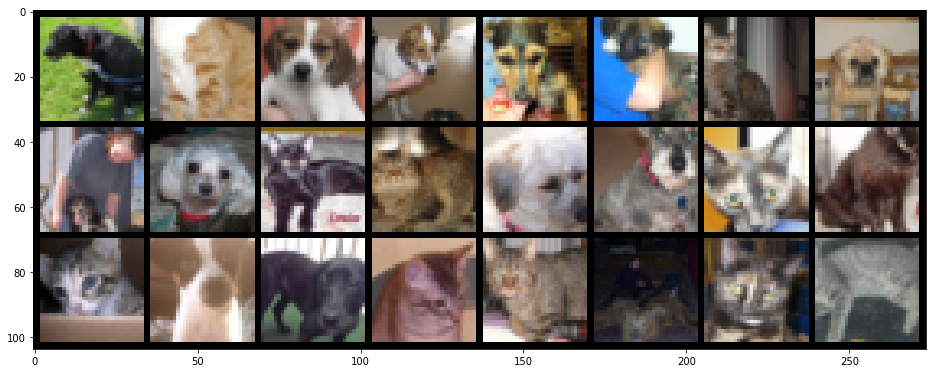

In [6]:
samples, labels = iter(dataloader_train).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [7]:
# transfer learning

#device = 'cuda'
#model = torchvision.models.densenet121(pretrained=True)
samples.shape

torch.Size([100, 3, 32, 32])

In [8]:
class DogsVsCatsNet(torch.nn.Module):
    def __init__(self):
        super(DogsVsCatsNet, self).__init__()
        
        self.conv1_1 = torch.nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=3, padding=0
        )
        self.conv1_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=3, padding=0
        )
        
        self.act1 = torch.nn.ReLU()
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, padding=0
        )
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=3, padding=0
        )
        
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(100, 400)
        self.act3 = torch.nn.ReLU()
    
        self.fc2 = torch.nn.Linear(400, 84)
        self.act4 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(84, 2)
    
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        
        return x

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.use_batch_norm = False
            
        activation_function  = torch.nn.ReLU()
        pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0
        )
        self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0
        )

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       

        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, padding=0
        )
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=3, padding=0
        )

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 2)
    
    def forward(self, x):

        x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        
        if self.use_batch_norm:
            x = self.bn1(x)
            
        x = self.pool1(x)
        

        x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        
        if self.use_batch_norm:
            x = self.bn2(x)
            
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [10]:
net = LeNet5()

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

In [12]:
# epochs = 1
# samples, labels = iter(dataloader).next()
# for epoch in range(epochs):
#     for samples, labels in dataloader:
#         print(labels)

In [13]:
epochs = 10
test_accuracy_history = []
test_loss_history = []

for epoch in range(epochs):
    for X_batch, y_batch in dataloader_train:
        optimizer.zero_grad()
        net.train()
        preds = net.forward(X_batch)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
        
    net.eval()
    
    X_test, y_test = iter(dataloader_train).next()
    test_preds = net.forward(X_test)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    
    print(accuracy)

tensor(0.5700)
tensor(0.6100)
tensor(0.6900)
tensor(0.6900)
tensor(0.8000)
tensor(0.6700)
tensor(0.6700)
tensor(0.7000)
tensor(0.7300)
tensor(0.7300)


In [ ]:
correct
#labels

In [ ]:
labels

In [ ]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

In [ ]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_densenet121.csv', index=False)
    

In [ ]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))